In [101]:
import pandas as pd
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from gensim.models import Word2Vec #install gensim # had to use this: pip install --upgrade gensim smart_open protobuf==3.20.0
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.stats import chi2_contingency


In [102]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dxcas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-

True

In [134]:
data = pd.read_pickle('data/data_cleaned.pkl')

### Tokenizing  
Do N-grams at this step

In [135]:
def tokenize_text(text, ngram='unigram'):
    tokens = nltk.word_tokenize(text)
    
    if ngram == 'unigram':
        return tokens
    elif ngram == 'bigram':
        return list(bigrams(tokens))
    elif ngram == 'trigram':
        return list(trigrams(tokens))
    else:
        raise ValueError("ngram should be either 'unigram', 'bigram', or 'trigram'")

# Unigram Tokenizing
data["comment_tokens"] = data["comment"].apply(lambda x: tokenize_text(x, 'unigram'))
data["parent_comment_tokens"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'unigram'))

# Bigram Tokenizing
data["comment_tokens_bigram"] = data["comment"].apply(lambda x: tokenize_text(x, 'bigram'))
data["parent_comment_tokens_bigram"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'bigram'))

# Trigram Tokenizing
data["comment_tokens_trigram"] = data["comment"].apply(lambda x: tokenize_text(x, 'trigram'))
data["parent_comment_tokens_trigram"] = data["parent_comment"].apply(lambda x: tokenize_text(x, 'trigram'))

In [136]:
"""
#spellchecking
#%pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()
data['comment_tokens'] = data['comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])
data['parent_comment_tokens'] = data['parent_comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])
"""

"\n#spellchecking\n#%pip install pyspellchecker\nfrom spellchecker import SpellChecker\nspell = SpellChecker()\ndata['comment_tokens'] = data['comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])\ndata['parent_comment_tokens'] = data['parent_comment_tokens'].apply(lambda tokens: [spell.correction(token) for token in tokens])\n"

### Removing Stop Words

In [137]:
#remove possible words from stop_words that can change meaning of text
stop_words = set(stopwords.words('english'))

to_remove = ["no","not"]
for word in to_remove:
    stop_words.remove(word)
# Filtering function for unigrams
def filter_unigrams(tokens):
    return [token for token in tokens if token not in stop_words]

# Filtering function for bigrams
def filter_bigrams(bigram_tokens):
    return [bigram for bigram in bigram_tokens if not all(word in stop_words for word in bigram)]

# Filtering function for trigrams
def filter_trigrams(trigram_tokens):
    return [trigram for trigram in trigram_tokens if not all(word in stop_words for word in trigram)]

# Apply the filtering functions
data["comment_tokens"] = data["comment_tokens"].apply(filter_unigrams)
data["parent_comment_tokens"] = data["parent_comment_tokens"].apply(filter_unigrams)

data["comment_tokens_bigram"] = data["comment_tokens_bigram"].apply(filter_bigrams)
data["parent_comment_tokens_bigram"] = data["parent_comment_tokens_bigram"].apply(filter_bigrams)

data["comment_tokens_trigram"] = data["comment_tokens_trigram"].apply(filter_trigrams)
data["parent_comment_tokens_trigram"] = data["parent_comment_tokens_trigram"].apply(filter_trigrams)

### Lemmatization

In [138]:
lemmatizer = WordNetLemmatizer()
# Lemmatize function for unigrams
def lemmatize_unigrams(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Lemmatize function for bigrams
def lemmatize_bigrams(bigram_tokens):
    return [' '.join([lemmatizer.lemmatize(word) for word in bigram]) for bigram in bigram_tokens]

# Lemmatize function for trigrams
def lemmatize_trigrams(trigram_tokens):
    return [' '.join([lemmatizer.lemmatize(word) for word in trigram]) for trigram in trigram_tokens]

# Apply the lemmatize functions
data["comment_tokens"] = data["comment_tokens"].apply(lemmatize_unigrams)
data["parent_comment_tokens"] = data["parent_comment_tokens"].apply(lemmatize_unigrams)

data["comment_tokens_bigram"] = data["comment_tokens_bigram"].apply(lemmatize_bigrams)
data["parent_comment_tokens_bigram"] = data["parent_comment_tokens_bigram"].apply(lemmatize_bigrams)

data["comment_tokens_trigram"] = data["comment_tokens_trigram"].apply(lemmatize_trigrams)
data["parent_comment_tokens_trigram"] = data["parent_comment_tokens_trigram"].apply(lemmatize_trigrams)

### Sentiment Analysis

In [139]:
sia = SentimentIntensityAnalyzer()
data['comment_score'] = data['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['parent_comment_score'] = data['parent_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

c:\Users\dxcas\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


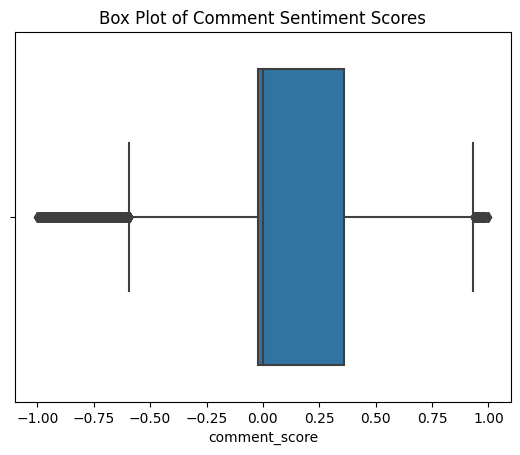

In [140]:
sns.boxplot(data['comment_score'])
plt.title('Box Plot of Comment Sentiment Scores')
plt.show()

c:\Users\dxcas\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


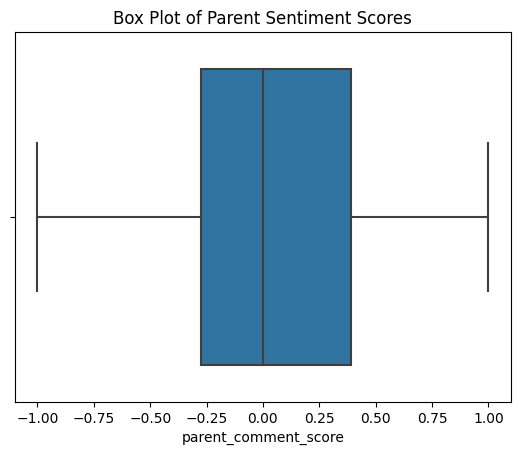

In [141]:
sns.boxplot(data['parent_comment_score'])
plt.title('Box Plot of Parent Sentiment Scores')
plt.show()

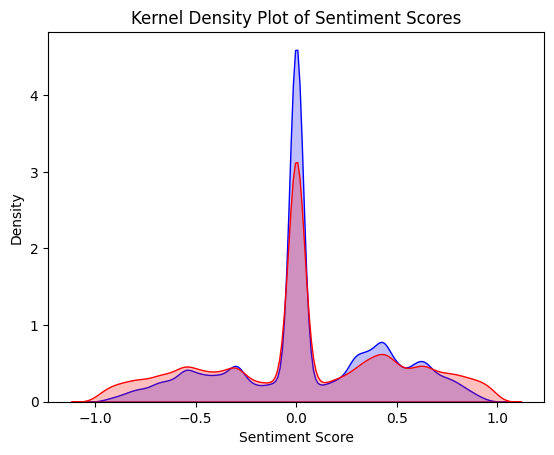

In [142]:
sns.kdeplot(data['comment_score'], shade=True, color = 'blue')
sns.kdeplot(data['parent_comment_score'], shade = True, color='red')
plt.title('Kernel Density Plot of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

In [143]:
def sentiment(score):
    if (score >= 0.25):
        return 'positive'
    elif (score <= -0.25):
        return 'negative'
    else:
        return 'neutral'
    
data['weighted_comment_sentiment_score'] = data['comment_score'].apply(sentiment)
data['weighted_parent_sentiment_score'] = data['parent_comment_score'].apply(sentiment)
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,parent_comment_score,weighted_comment_sentiment_score,weighted_parent_sentiment_score
0,i just want his mutator for that!,"at 0:06, if you look closely you can see that ...",1,"[want, mutator, !]","[0:06, ,, look, closely, see, fake, two, ball,...","[just want, want his, his mutator, mutator for...","[at 0:06, 0:06 ,, , if, you look, look closely...","[i just want, just want his, want his mutator,...","[at 0:06 ,, 0:06 , if, , if you, if you look, ...",0.1511,-0.4767,neutral,negative
1,i am the adultierest.,an adultier adult.,0,"[adultierest, .]","[adultier, adult, .]","[the adultierest, adultierest .]","[an adultier, adultier adult, adult .]","[am the adultierest, the adultierest .]","[an adultier adult, adultier adult .]",0.0000,0.0000,neutral,neutral
2,"take a cold shower, it will help tremendously.","day 7 my balls hurt, i feel dizzy, losing conf...",0,"[take, cold, shower, ,, help, tremendously, .]","[day, 7, ball, hurt, ,, feel, dizzy, ,, losing...","[take a, a cold, cold shower, shower ,, , it, ...","[day 7, 7 my, my ball, ball hurt, hurt ,, , i,...","[take a cold, a cold shower, cold shower ,, sh...","[day 7 my, 7 my ball, my ball hurt, ball hurt ...",0.4019,0.3178,positive,positive
3,"14 hours later, and she has not responded yet.",hard to keep a straight face knowing that the ...,0,"[14, hour, later, ,, not, responded, yet, .]","[hard, keep, straight, face, knowing, pillar, ...","[14 hour, hour later, later ,, , and, ha not, ...","[hard to, to keep, keep a, a straight, straigh...","[14 hour later, hour later ,, later , and, , a...","[hard to keep, to keep a, keep a straight, a s...",0.0000,-0.7876,neutral,negative
4,"""but i am such a nice guy!""",why pandas are not mating,0,"[``, nice, guy, !, '']","[panda, not, mating]","[`` but, a nice, nice guy, guy !, ! '']","[why panda, panda are, are not, not mating]","[`` but i, such a nice, a nice guy, nice guy !...","[why panda are, panda are not, are not mating]",0.6114,0.0000,positive,neutral


In [144]:
contingency_table = pd.crosstab(data['label'], data['weighted_comment_sentiment_score'])

# Display the contingency table
print(contingency_table)

weighted_comment_sentiment_score  negative  neutral  positive
label                                                        
0                                    18844    52170     29948
1                                    21556    45972     33529


In [145]:
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-Square Value: {chi2}')
print(f'P-value: {p}')

Chi-Square Value: 775.4522926669528
P-value: 4.098964506892753e-169


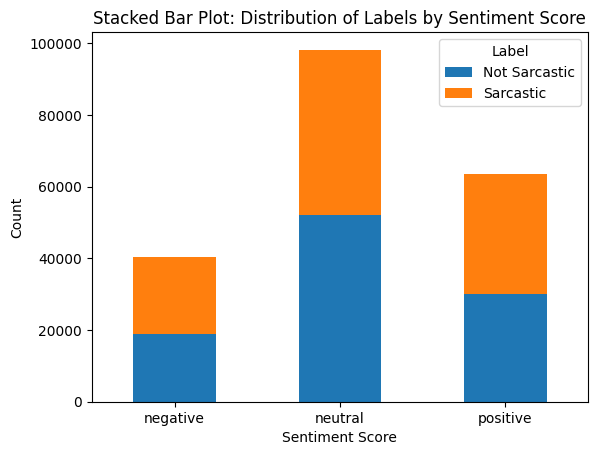

In [146]:
stacked_data = data.groupby(['weighted_comment_sentiment_score', 'label']).size().unstack().fillna(0)

stacked_data.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot: Distribution of Labels by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['Not Sarcastic', 'Sarcastic'])
plt.show()

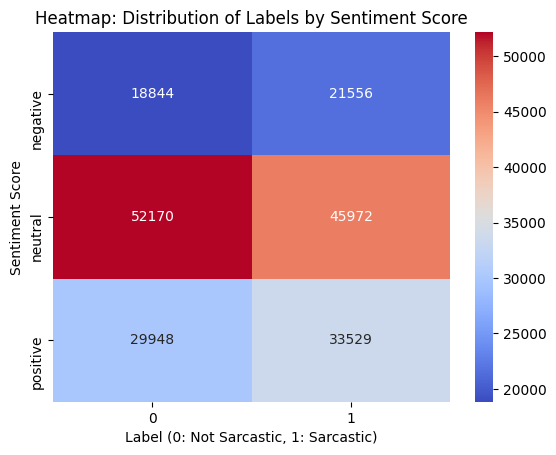

In [147]:
heatmap_data = data.groupby(['weighted_comment_sentiment_score', 'label']).size().unstack().fillna(0)
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap: Distribution of Labels by Sentiment Score')
plt.xlabel('Label (0: Not Sarcastic, 1: Sarcastic)')
plt.ylabel('Sentiment Score')
plt.show()

In [148]:
# One Hot Encode Weighted Sentiment Scores
data = pd.get_dummies(data, columns = ['weighted_parent_sentiment_score','weighted_comment_sentiment_score'], drop_first=True)

In [149]:
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,parent_comment_score,weighted_parent_sentiment_score_neutral,weighted_parent_sentiment_score_positive,weighted_comment_sentiment_score_neutral,weighted_comment_sentiment_score_positive
0,i just want his mutator for that!,"at 0:06, if you look closely you can see that ...",1,"[want, mutator, !]","[0:06, ,, look, closely, see, fake, two, ball,...","[just want, want his, his mutator, mutator for...","[at 0:06, 0:06 ,, , if, you look, look closely...","[i just want, just want his, want his mutator,...","[at 0:06 ,, 0:06 , if, , if you, if you look, ...",0.1511,-0.4767,0,0,1,0
1,i am the adultierest.,an adultier adult.,0,"[adultierest, .]","[adultier, adult, .]","[the adultierest, adultierest .]","[an adultier, adultier adult, adult .]","[am the adultierest, the adultierest .]","[an adultier adult, adultier adult .]",0.0000,0.0000,1,0,1,0
2,"take a cold shower, it will help tremendously.","day 7 my balls hurt, i feel dizzy, losing conf...",0,"[take, cold, shower, ,, help, tremendously, .]","[day, 7, ball, hurt, ,, feel, dizzy, ,, losing...","[take a, a cold, cold shower, shower ,, , it, ...","[day 7, 7 my, my ball, ball hurt, hurt ,, , i,...","[take a cold, a cold shower, cold shower ,, sh...","[day 7 my, 7 my ball, my ball hurt, ball hurt ...",0.4019,0.3178,0,1,0,1
3,"14 hours later, and she has not responded yet.",hard to keep a straight face knowing that the ...,0,"[14, hour, later, ,, not, responded, yet, .]","[hard, keep, straight, face, knowing, pillar, ...","[14 hour, hour later, later ,, , and, ha not, ...","[hard to, to keep, keep a, a straight, straigh...","[14 hour later, hour later ,, later , and, , a...","[hard to keep, to keep a, keep a straight, a s...",0.0000,-0.7876,0,0,1,0
4,"""but i am such a nice guy!""",why pandas are not mating,0,"[``, nice, guy, !, '']","[panda, not, mating]","[`` but, a nice, nice guy, guy !, ! '']","[why panda, panda are, are not, not mating]","[`` but i, such a nice, a nice guy, nice guy !...","[why panda are, panda are not, are not mating]",0.6114,0.0000,1,0,0,1


### Basic Text Features
- extracted these features mostly from the original sentences
- extracted token count, unique token count and mean token length

In [150]:
#data = data[['label','comment', 'parent_comment']]
###pre-tokenised###
# Word Count
data['comment_word_count'] = data['comment'].apply(lambda x: len(str(x).split()))
data['parent_comment_word_count'] = data['parent_comment'].apply(lambda x: len(str(x).split()))
data['comment_token_count'] = data['comment_tokens'].apply(lambda x: len(x))
data['parent_comment_token_count'] = data['parent_comment_tokens'].apply(lambda x: len(x))

# Unique Word Count
data['comment_unique_word_count'] = data['comment'].apply(lambda x: len(set(str(x).split())))
data['parent_comment_unique_word_count'] = data['parent_comment'].apply(lambda x: len(set(str(x).split())))
data['comment_unique_token_count'] = data['comment_tokens'].apply(lambda x: len(set(x)))
data['parent_comment_unique_token_count'] = data['parent_comment_tokens'].apply(lambda x: len(set(x)))

# Stop Word Count
stop = stopwords.words('english')
data['comment_stopword_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop]))
data['parent_comment_stopword_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop]))

# Mean Word Length
data['comment_mean_word_length'] = data['comment'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
data['parent_comment_mean_word_length'] = data['parent_comment'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
data['comment_mean_token_length'] = data['comment_tokens'].apply(lambda x: np.mean([len(token) for token in x]))
data['parent_comment_mean_token_length'] = data['parent_comment_tokens'].apply(lambda x: np.mean([len(token) for token in x]))

# Character Count
data['comment_char_count'] = data['comment'].apply(lambda x: len(str(x)))
data['parent_comment_char_count'] = data['parent_comment'].apply(lambda x: len(str(x)))

# Punctuation Count
data['comment_punctuation_count'] = data['comment'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))
data['parent_comment_punctuation_count'] = data['parent_comment'].apply(lambda x: len([char for char in str(x) if char in string.punctuation]))

# Hashtag and Number Count
data['comment_hashtag_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))
data['parent_comment_hashtag_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))

data['comment_number_count'] = data['comment'].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))
data['parent_comment_number_count'] = data['parent_comment'].apply(lambda x: len([word for word in str(x).split() if word.isdigit()]))



c:\Users\dxcas\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [151]:
data.isna().sum()

comment                                        0
parent_comment                                 0
label                                          0
comment_tokens                                 0
parent_comment_tokens                          0
comment_tokens_bigram                          0
parent_comment_tokens_bigram                   0
comment_tokens_trigram                         0
parent_comment_tokens_trigram                  0
comment_score                                  0
parent_comment_score                           0
weighted_parent_sentiment_score_neutral        0
weighted_parent_sentiment_score_positive       0
weighted_comment_sentiment_score_neutral       0
weighted_comment_sentiment_score_positive      0
comment_word_count                             0
parent_comment_word_count                      0
comment_token_count                            0
parent_comment_token_count                     0
comment_unique_word_count                      0
parent_comment_uniqu

In [152]:
# Filtering out all the entries with no comment, no comment tokens, no parent comments (mean of feature = 0)
data_filtered = data.dropna()
print('Number of Entries before filter:', len(data))
print('Number of Entries after filter:', len(data_filtered))

data = data_filtered


Number of Entries before filter: 202019
Number of Entries after filter: 201264


### Bag of Words

In [153]:
documents_comments = data['comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))
documents_parent_comments = data['parent_comment_tokens'].apply(lambda tokens_list:' '.join(tokens_list))

In [154]:
# For comments
vectorizer_comments = CountVectorizer(min_df=4, ngram_range=(1, 3))
bow_matrix_comments = vectorizer_comments.fit_transform(documents_comments)
bow_matrix_csr = csr_matrix(bow_matrix_comments)
data['comment_bow'] = [row for row in bow_matrix_csr]

# For parent comments
vectorizer_parent_comments = CountVectorizer(min_df=4, ngram_range=(1, 3))
bow_matrix_parent_comments = vectorizer_parent_comments.fit_transform(documents_parent_comments)
bow_matrix_csr_parent = csr_matrix(bow_matrix_parent_comments)
data['parent_comment_bow'] = [row for row in bow_matrix_csr_parent]


In [155]:
### Function to extract feature names from CSR representation
feature_names_bow = vectorizer_comments.get_feature_names_out() # to reverse
def bow_to_words(bow_vector, feature_names):
    # Convert the sparse matrix row to a dense array
    array = bow_vector.toarray().flatten()
    # Get the tokens that have a count > 0
    tokens = [feature_names[i] for i, count in enumerate(array) if count > 0]
    return tokens

In [156]:
bow_to_words(data['comment_bow'].iloc[0],feature_names_bow) # we see that the trigrams are not present in this one example- likely due to the trigrams being much more rare.

['want']

### TD-IDF

In [157]:
tdvectorizer_comments = TfidfVectorizer(min_df = 4, ngram_range=(1, 3))
tdidf_matrix_comments = tdvectorizer_comments.fit_transform(documents_comments)
tdidf_matrix_csr = csr_matrix(tdidf_matrix_comments)
data['comment_tdidf'] = [row for row in tdidf_matrix_csr]

tdvectorizer_parent_comments = TfidfVectorizer(min_df = 4, ngram_range=(1, 3))
tdidf_matrix_parent_comments = tdvectorizer_parent_comments.fit_transform(documents_parent_comments)
tdidf_matrix_csr_parent = csr_matrix(tdidf_matrix_parent_comments)
data['parent_comment_tdidf'] = [row for row in tdidf_matrix_csr_parent]

In [158]:
feature_names_tfidf = tdvectorizer_comments.get_feature_names_out()
def tfidf_to_words(tfidf_row, feature_names):
    """
    Convert a TF-IDF row to its word representation.
    :param tfidf_row: A single row from a sparse matrix.
    :param feature_names: List of feature names from the TF-IDF vectorizer.
    :return: List of words from the TF-IDF row.
    """
    dense_tfidf = tfidf_row.toarray().flatten()
    words_indices = dense_tfidf.nonzero()[0]
    words = [(feature_names[index], dense_tfidf[index]) for index in words_indices]
    return words

reducing size of tf-idf map for RNN

In [159]:
tdvectorizer_comments_nn = TfidfVectorizer(min_df = 20, ngram_range=(1, 3))
tdidf_matrix_comments_nn = tdvectorizer_comments_nn.fit_transform(documents_comments)
tdidf_matrix_nn_csr = csr_matrix(tdidf_matrix_comments_nn)
data['comment_tdidf_nn'] = [row for row in tdidf_matrix_nn_csr]
len(tdvectorizer_comments_nn.get_feature_names_out())# if we increase min_df to 10, number of features reduces to 15799
tdvectorizer_comments_nn.get_feature_names_out()

array(['00', '000', '000 000', ..., 'zone', 'zoo', 'zoom'], dtype=object)

In [160]:
# Testing out Extraction
df = data.head(10)
#print(data.columns)
#df[['comment_bow', 'comment_tdidf']]
print(df['comment_bow'].iloc[3])
print(bow_to_words(df['comment_bow'].iloc[3], feature_names_bow))
print(df['comment_tdidf'].iloc[3])
print(tfidf_to_words(df['comment_tdidf'].iloc[3], feature_names_tfidf))

  (0, 156)	1
  (0, 16021)	1
  (0, 18394)	1
  (0, 24289)	1
  (0, 31745)	1
  (0, 43648)	1
  (0, 158)	1
  (0, 16031)	1
  (0, 18396)	1
['14', '14 hour', 'hour', 'hour later', 'later', 'later not', 'not', 'responded', 'yet']
  (0, 18396)	0.4374609357012079
  (0, 16031)	0.4044534928331277
  (0, 158)	0.43058693996301034
  (0, 43648)	0.24745695197921966
  (0, 31745)	0.3738793196620071
  (0, 24289)	0.10172406520106882
  (0, 18394)	0.29166403580172623
  (0, 16021)	0.2558456319519351
  (0, 156)	0.31264487464207613
[('14', 0.31264487464207613), ('14 hour', 0.43058693996301034), ('hour', 0.2558456319519351), ('hour later', 0.4044534928331277), ('later', 0.29166403580172623), ('later not', 0.4374609357012079), ('not', 0.10172406520106882), ('responded', 0.3738793196620071), ('yet', 0.24745695197921966)]


In [161]:
data.to_pickle("data/data_w_feature_eng.pkl")

In [162]:
data.head()

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,...,parent_comment_punctuation_count,comment_hashtag_count,parent_comment_hashtag_count,comment_number_count,parent_comment_number_count,comment_bow,parent_comment_bow,comment_tdidf,parent_comment_tdidf,comment_tdidf_nn
0,i just want his mutator for that!,"at 0:06, if you look closely you can see that ...",1,"[want, mutator, !]","[0:06, ,, look, closely, see, fake, two, ball,...","[just want, want his, his mutator, mutator for...","[at 0:06, 0:06 ,, , if, you look, look closely...","[i just want, just want his, want his mutator,...","[at 0:06 ,, 0:06 , if, , if you, if you look, ...",0.1511,...,3,0,0,0,0,"(0, 40466)\t1","(0, 77)\t1\n (0, 48477)\t1\n (0, 14789)\t1...","(0, 40466)\t1.0","(0, 8031)\t0.3814012370841314\n (0, 78385)\...","(0, 7585)\t1.0"
1,i am the adultierest.,an adultier adult.,0,"[adultierest, .]","[adultier, adult, .]","[the adultierest, adultierest .]","[an adultier, adultier adult, adult .]","[am the adultierest, the adultierest .]","[an adultier adult, adultier adult .]",0.0000,...,1,0,0,0,0,,"(0, 2984)\t1",,"(0, 2984)\t1.0",
2,"take a cold shower, it will help tremendously.","day 7 my balls hurt, i feel dizzy, losing conf...",0,"[take, cold, shower, ,, help, tremendously, .]","[day, 7, ball, hurt, ,, feel, dizzy, ,, losing...","[take a, a cold, cold shower, shower ,, , it, ...","[day 7, 7 my, my ball, ball hurt, hurt ,, , i,...","[take a cold, a cold shower, cold shower ,, sh...","[day 7 my, 7 my ball, my ball hurt, ball hurt ...",0.4019,...,21,0,0,0,2,"(0, 36813)\t1\n (0, 5967)\t1\n (0, 34025)\...","(0, 48477)\t3\n (0, 93259)\t1\n (0, 8028)\...","(0, 38888)\t0.6164354520147152\n (0, 15399)...","(0, 88938)\t0.1075408168007538\n (0, 60677)...","(0, 3047)\t0.4371486580462719\n (0, 6402)\t..."
3,"14 hours later, and she has not responded yet.",hard to keep a straight face knowing that the ...,0,"[14, hour, later, ,, not, responded, yet, .]","[hard, keep, straight, face, knowing, pillar, ...","[14 hour, hour later, later ,, , and, ha not, ...","[hard to, to keep, keep a, a straight, straigh...","[14 hour later, hour later ,, later , and, , a...","[hard to keep, to keep a, keep a straight, a s...",0.0000,...,2,0,0,1,0,"(0, 156)\t1\n (0, 16021)\t1\n (0, 18394)\t...","(0, 58200)\t1\n (0, 37180)\t1\n (0, 42797)...","(0, 18396)\t0.4374609357012079\n (0, 16031)...","(0, 60069)\t0.22915217806370072\n (0, 70768...","(0, 8070)\t0.36499814894293503\n (0, 5974)\..."
4,"""but i am such a nice guy!""",why pandas are not mating,0,"[``, nice, guy, !, '']","[panda, not, mating]","[`` but, a nice, nice guy, guy !, ! '']","[why panda, panda are, are not, not mating]","[`` but i, such a nice, a nice guy, nice guy !...","[why panda are, panda are not, are not mating]",0.6114,...,0,0,0,0,0,"(0, 23658)\t1\n (0, 14678)\t1\n (0, 23669)\t1","(0, 58200)\t1\n (0, 64885)\t1\n (0, 51555)\t1","(0, 23669)\t0.7547239180695782\n (0, 14678)...","(0, 51555)\t0.7509977106269409\n (0, 64885)...","(0, 4492)\t0.7547239180695782\n (0, 2915)\t..."


In [163]:
data[data["comment_mean_word_length"].isna()]

,comment,parent_comment,label,comment_tokens,parent_comment_tokens,comment_tokens_bigram,parent_comment_tokens_bigram,comment_tokens_trigram,parent_comment_tokens_trigram,comment_score,...,parent_comment_punctuation_count,comment_hashtag_count,parent_comment_hashtag_count,comment_number_count,parent_comment_number_count,comment_bow,parent_comment_bow,comment_tdidf,parent_comment_tdidf,comment_tdidf_nn
